In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import zipfile
import io  
import torch
import torch.nn as nn
import torchtext
import os, requests, shutil
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

paths=list()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


Reading data into pd.DataFrames

In [74]:
paths

['/kaggle/input/quora-insincere-questions-classification/sample_submission.csv',
 '/kaggle/input/quora-insincere-questions-classification/embeddings.zip',
 '/kaggle/input/quora-insincere-questions-classification/train.csv',
 '/kaggle/input/quora-insincere-questions-classification/test.csv']

In [75]:
train = pd.read_csv(paths[2])
test = pd.read_csv(paths[3])
sub = pd.read_csv(paths[0])

In [76]:
#Choosing device 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [77]:
train

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


Download glove vectors for words 

In [78]:
!unzip /kaggle/input/quora-insincere-questions-classification/embeddings.zip 

Archive:  /kaggle/input/quora-insincere-questions-classification/embeddings.zip
replace glove.840B.300d/glove.840B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [79]:
from torchtext.vocab import Vectors
glove = Vectors("glove.840B.300d/glove.840B.300d.txt", cache='glove', url = None)

Pre-processing part for training and test data. Here are some of the symbols I have seen in the data while just looking into the vocabulary constructed in the later part of the assignment and the symbols 'basic_english' tokenizer was not able to separate from words. So I iterate through the words and do it myself. Same goes for numbers.


In [80]:
symbols = ['₹', '≠', '€', '"', '‘', '’', '~', '[', ']', '{', '}', '/', '\\', '=', '*', '+', '-', 
                    '|', '&', '^', '>', '%',  '@',"“","”", "∇", "√"]
def removeSymbols(x):
    x = str(x)
    for sym in symbols:
        x = x.replace(sym, f' {sym} ')
    return x
def removeNumbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]', '#', x)
    return x
train["question_text"] = train["question_text"].apply(lambda x: removeSymbols(x.lower()))
test["question_text"] = test["question_text"].apply(lambda x: removeSymbols(x.lower()))
train["question_text"] = train["question_text"].apply(lambda x: removeNumbers(x.lower()))
test["question_text"] = test["question_text"].apply(lambda x: removeNumbers(x.lower()))

This is the graph showing lengths of quora questions. We're seeing that "right tale" after just 50, so I'll take that as a maximum length for questions

In [81]:
seq_lens = [len(text) for text in train["question_text"]]

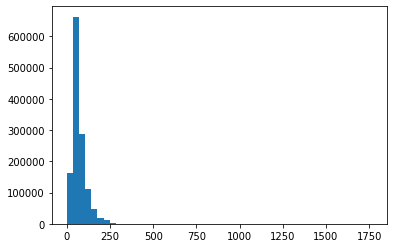

In [82]:
plt.hist(seq_lens, bins=50);

In [83]:
MAX_SEQ_LEN=50

The most frequent words of both classes

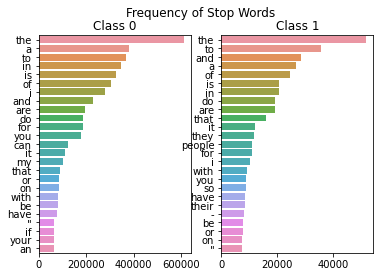

In [84]:
import seaborn as sns
from collections import defaultdict, Counter
fig, axes = plt.subplots(1,len(train['target'].unique()))
fig.suptitle('Frequency of Stop Words')
for i,t in enumerate(train['target'].unique()):
    dct=defaultdict(int)
    curr=train[train['target']==t]
    words=curr['question_text'].str.cat().split()
    counter=Counter(words)
    most=counter.most_common()
    x=[]
    y=[]
    for word,count in most[:25]:
        x.append(word)
        y.append(count)
    sns.barplot(ax=axes[i],x=y,y=x)
    axes[i].set_title("Class " + str(t))

Now let's see the proportion of our classes (labels) in training data. In other words, proportion between sincere and non-sincere questions. 

(array([1225312.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   80810.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

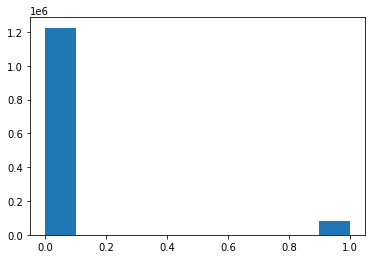

In [85]:
targetclasses=[t for t in train['target']]
plt.hist(targetclasses)

We've seen that our data is quite unbalanced. The number of 1-s in our data is much smaller than the number of 0-s. So, on our next step, which is to divide data into training and validation sets, I've decided to do this separately for each classes and then merge them again. We'll also take this into consideration afterwards, during training of our neural network.

In [86]:
trainfirsttar=train[train['target']==0]
trainsecondtar=train[train['target']==1]
trainFx,validFx, trainFy, validFy = train_test_split(trainfirsttar['question_text'], trainfirsttar['target'], train_size=0.7, test_size=0.3)
trainSx, validSx, trainSy, validSy = train_test_split(trainsecondtar['question_text'], trainsecondtar['target'], train_size=0.7, test_size=0.3)
trainX=pd.DataFrame(pd.concat([trainFx, trainSx], axis=0))
trainY=pd.DataFrame(pd.concat([trainFy, trainSy], axis=0))
validX=pd.DataFrame(pd.concat([validFx, validSx], axis=0))
validY=pd.DataFrame(pd.concat([validFy, validSy], axis=0))
trainset=pd.DataFrame(pd.concat([trainX,trainY],axis=1))
validationset=pd.DataFrame(pd.concat([validX,validY],axis=1))


In [87]:
#Get Tokenizer for our questions 
tokenizer = get_tokenizer('basic_english')

In the next few cells, I tokenize our questions and construct torch.vocabulary from our training set. Also, I set '<unk>' for default index so that when there are some typos or still unknown words, the algorithm does not crush

In [88]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

yield_tokens(train["question_text"]) 

vocab = build_vocab_from_iterator(iterator=yield_tokens(trainset["question_text"]), # Vocabulary is built using training data, NOT valid/test sets.
                                 min_freq=3, # Omit tokens which occur less than min_freq times in the entire training data.
                                  specials=["<pad>", "<unk>"])
vocab.set_default_index(vocab['<unk>'])

In [89]:
vecs = glove.get_vecs_by_tokens(vocab.get_itos())

In [90]:
vecs.shape

torch.Size([56421, 300])

This is our class for Neural Network. 

In [91]:
class ClassifierModel(nn.Module):
    def __init__(self, init=True):
        super().__init__()

        self.emb = nn.Embedding(num_embeddings=len(vocab), 
                                embedding_dim=300,
                                padding_idx=0, 
                                sparse=False)

        # here we can decide if we want to use pre-trained embeddings or not.
        if init:
            self.emb.weight = nn.Parameter(vecs) # initializing embedding weights with pre-trained vectors.
            self.emb.weight.requires_grad = False # we do not train embeddings here.
        self.dropout = nn.Dropout(0.1) #In order to avoid overfitting, I've decided to use dropout with p=0.1
        self.firstLayer = nn.Linear(300, 100, bias=True)
        self.secondLayer = nn.Linear(100, 25, bias=True)
        self.thirdLayer = nn.Linear(25, 2, bias=True)
        self.relu = nn.ReLU()

    def forward(self, inp):
        sent_vec = self.emb(inp).sum(dim=1)
        return  (self.relu(self.thirdLayer(self.secondLayer(self.firstLayer(self.dropout(sent_vec))))))


In [92]:
# This function takes tokenized questions and first, if the number of words exceeds MAX_SEQ_LEN, it just throws them away, 
# so that our questions don't contain more than 50 words (we are making an assumption that 50 words are necessary to answer)
# our question as most of the data have this number, and also it replaces words with their corresponding embedding vectors
def truncate(tokenized_text: list):
    return tokenized_text[:min(MAX_SEQ_LEN, len(tokenized_text))] 
text_pipeline = lambda x: vocab(truncate(tokenizer(x)))

In the next part, we construct DataLoaders for our data. As DataLoader gets Dataset as a parameter, I had to write simple
implementation of my class which extends Dataset. So I construct my custom Datasets on our training and validation sets, and then create DataLoaders for them

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#This is collate_batch function we'll use for our DataLoaders 
def collate_batch(batch):
    label_list, text_list = [], []
    for text, label in batch:
        label_list.append(label)
        x = torch.zeros(MAX_SEQ_LEN, dtype=torch.int32)
        processed_text = text_pipeline(text)
        x[:len(processed_text)] = torch.tensor(processed_text, dtype=torch.int32)
        text_list.append(x)
    label_list = torch.tensor(label_list, dtype=torch.int32)
    text_list = torch.stack(text_list, dim=0)
    return text_list, label_list


In [94]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):

    def __init__(self,x,y):

        self.x_train=x.values
        self.y_train=y.values

    def __len__(self):
        return len(self.y_train)
  
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]


trainingds = MyDataset(trainset['question_text'], trainset['target'])
validationds = MyDataset(validationset['question_text'],validationset['target'])

traindl = DataLoader(trainingds, 
                      batch_size=128, 
                      shuffle=True, 
                      collate_fn=collate_batch)

validationdl = DataLoader(validationds, 
                      batch_size=128*2, 
                      shuffle=False, 
                      collate_fn=collate_batch)


These are just functions for plotting confusion matrix and calculating accuracy on validation set

In [95]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def calc_accuracy(model: nn.Module):
    
    model.eval()

    Y, Y_PRED, Y_VAL = [], [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(validationdl):
            y_pred = model(x.to(DEVICE))
            Y.extend(y.tolist())
            Y_PRED.extend(y_pred.argmax(dim=1).tolist())
            Y_VAL.append(y_pred.cpu())

    cnf_matrix = confusion_matrix(Y, Y_PRED)

    print('VALID LOSS: ', torch.nn.functional.cross_entropy(torch.cat(Y_VAL, dim=0), torch.LongTensor(Y)).item())

    plt.figure(figsize=(5, 5))
    plot_confusion_matrix(cnf_matrix, 
                        classes=['Neg', 'Pos'],
                        title='Confusion Matrix')
  
    plt.show()

    model.train()



Here comes the actual training part for our model. Remember our data was quite unbalanced, so I use sklearn.utils.class_weight in order to 'balance' this data and get my model to learn better.

In [96]:
from sklearn.utils import class_weight

Epoch 1 Loss 0.7141965627670288
Epoch 2 Loss 0.34447890520095825
Epoch 3 Loss 0.2699449956417084
VALID LOSS:  0.39620527625083923
Confusion matrix, without normalization


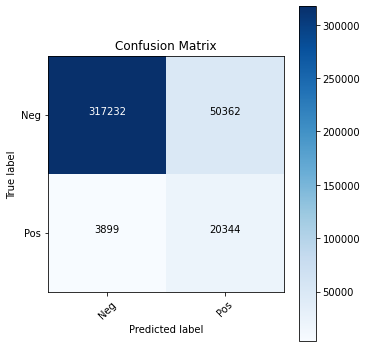

Epoch 4 Loss 0.5115970969200134
Epoch 5 Loss 0.3134080171585083
Epoch 6 Loss 0.2914881110191345
VALID LOSS:  0.387241929769516
Confusion matrix, without normalization


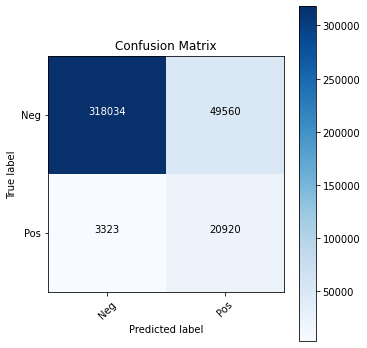

Epoch 7 Loss 0.5100399851799011
Epoch 8 Loss 0.29634740948677063
Epoch 9 Loss 0.2890169620513916
VALID LOSS:  0.3699774742126465
Confusion matrix, without normalization


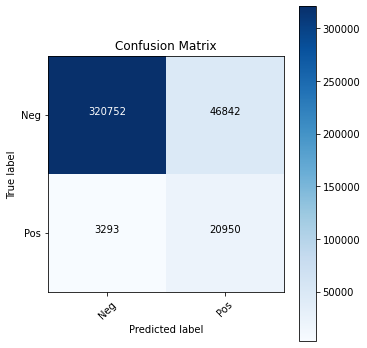

Epoch 10 Loss 0.2754581570625305
Epoch 11 Loss 0.3182445168495178
Epoch 12 Loss 0.25373375415802
VALID LOSS:  0.3591509759426117
Confusion matrix, without normalization


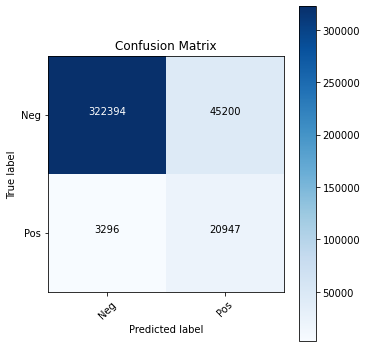

Epoch 13 Loss 0.23333774507045746
Epoch 14 Loss 0.4590543210506439
Epoch 15 Loss 0.22229863703250885
VALID LOSS:  0.3538854718208313
Confusion matrix, without normalization


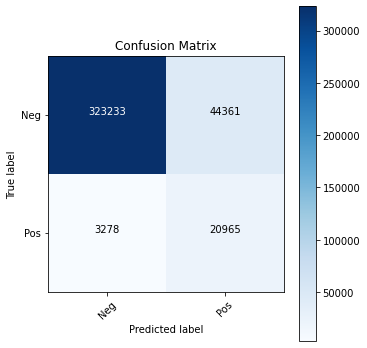

Epoch 16 Loss 0.4653993546962738
Epoch 17 Loss 0.28842538595199585
Epoch 18 Loss 0.25768932700157166
VALID LOSS:  0.34057050943374634
Confusion matrix, without normalization


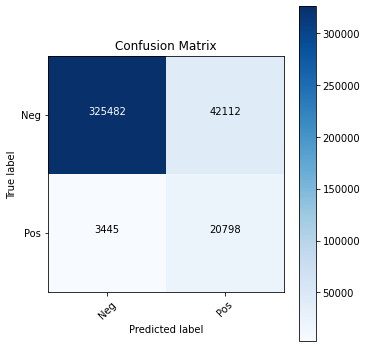

Epoch 19 Loss 0.6094401478767395
Epoch 20 Loss 0.3173774778842926


In [97]:

# Train loop is a place where we define model and write training logic - mainly SGD.

def train_loop():

  # define optimizer - algorithm used for optimizing loss function.
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

    class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=train['target'].to_numpy())
    class_weights = torch.tensor(class_weights,dtype=torch.float).to(DEVICE)
  # loss function. We specify that we want averaging across batch dimension in order to get batch-averaged loss.
    crit = nn.CrossEntropyLoss(reduction='mean', weight=class_weights)

  # we calculate accuracy (confusion matrix in this case) before training begins.
  #  calc_accuracy(model)

    for epoch in range(20): # number of epochs - full passes over the data
        for i, (x, y) in enumerate(traindl): # iterating over training batches - in random fasion.
          # this needs to be runned before doing gradient step. PyTorch by default accumulates previous gradients from previous steps so we need to tell it to clear everything.
            optimizer.zero_grad()

          # forward pass
            y_pred = model(x.to(DEVICE))

        # loss computation
            loss = crit(y_pred, y.to(DEVICE).long())

          # running backpropagation algorithm (computing loss gradients with respect to neural network weights)
            loss.backward()

          # doing SGD step and updating neural network weights
            optimizer.step()
            
        print('Epoch', epoch + 1, 'Loss', loss.item())

        if (epoch + 1) % 3 == 0:
            calc_accuracy(model)

# define model and move it's weightss to appropriate device
model = ClassifierModel(True).to(DEVICE)
train_loop()

Now that we have our model trained, we need to get predictions on our test data. Because of this, I did the same to test data as training and validation sets. I constructed custom Dataset, for which I had to do a little trick for syntactic reasons. As my Dataset gets X,Y for parameters and in our test data we don't actually have that 'Y', I just passed the question text column twice. I don't use the second one, it's just for the syntax.

So I construct dataset and then dataloader for my test set, then I call model.eval() function and get predictions for each of the testData elements. I use argmax for returned predictions to distribute them into classes (0 or 1). Then just construct new dataframe for my submission and save that to csv file. 

In [98]:
def collate_test(batch):
    text_list = []
    for text,text in batch:
        x = torch.zeros(MAX_SEQ_LEN, dtype=torch.int32)
        processed_text = text_pipeline(text)
        x[:len(processed_text)] = torch.tensor(processed_text, dtype=torch.int32)
        text_list.append(x)
    text_list = torch.stack(text_list, dim=0)
    return text_list

testds = MyDataset(test['question_text'],test['question_text'])
testdl= DataLoader(testds, batch_size=1, shuffle=False, collate_fn=collate_test)

In [99]:
test_targets =[]
model.eval()
for i, x in enumerate(testdl): # iterating over training batches - in random fasion.
    y_pred = model(x.to(DEVICE))
    test_targets += [0 if y_pred[0][0] > y_pred[0][1] else 1]


In [100]:
sb=pd.DataFrame({"qid": test['qid'], "prediction": test_targets})

In [101]:
sb.to_csv("submission.csv", index=False)

Let's see some examples of how our model works on some sincere and insincere questions.

In [108]:
insinceres=["If both Honey Singh and Justin Bieber fall from the 5th floor, who will survive?",
            "If Hispanics are so proud of their countries, why do they move out?",
            "If Hispanics are so proud of their countries, why do they move out?"]
sinceres=["How were the Calgary Flames founded?", 
          "Can we use our external hard disk as a OS as well as for data storage.will the data be affected?",
         "Can you make Amazon Alexa trigger events in the browser?"]

In [109]:
inspd = pd.DataFrame({"question" : insinceres})
insincds=MyDataset(inspd['question'],inspd['question'])
ins_targets =[]
insdl= DataLoader(insincds, batch_size=1, shuffle=False, collate_fn=collate_test)
for i, x in enumerate(insdl): # iterating over training batches - in random fasion.
    y_pred = model(x.to(DEVICE))
    ins_targets += [0 if y_pred[0][0] > y_pred[0][1] else 1]

In [110]:
ins_targets

[1, 1, 1]

In [111]:
spd = pd.DataFrame({"question" : sinceres})
sincds=MyDataset(spd['question'],spd['question'])
sin_targets =[]
sindl= DataLoader(sincds, batch_size=1, shuffle=False, collate_fn=collate_test)
for i, x in enumerate(sindl): # iterating over training batches - in random fasion.
    y_pred = model(x.to(DEVICE))
    sin_targets += [0 if y_pred[0][0] > y_pred[0][1] else 1]

In [112]:
sin_targets

[0, 0, 0]